## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency
* bidirecitonal promotors X
* shared enhancers
* shared go term
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [223]:
import numpy as np
import pandas as pd
import scipy as sp
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/new_clusters/proteincoding_rewrite.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Cells_Cultured_fibroblasts'

protien_coding_only = True

## load in data
cluster df, expression df, gencode

In [66]:
# load in cluster data for a single tissue
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

# load in cluster data for all tissues
all_tissue_cluster_dfs={}
for tissue_id in tissue_ids: 
    all_tissue_cluster_dfs[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

In [67]:
# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')

# load in expression data for all tissues 
all_tissue_expression_dfs={}
for tissue_id in tissue_ids: 
    all_tissue_expression_dfs[tissue_id] = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')


In [133]:
# load in gene data
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]
full_gencode['gene_type'] = full_gencode['info'].str.split(';').str[2].str.split('\"').str[-2]
full_gencode['gene_name'] = full_gencode['info'].str.split(';').str[3].str.split('\"').str[-2]


# add in the start and end info
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])
full_gencode['gene_end'] = np.where(full_gencode['strand'] == '-', full_gencode['start'], full_gencode['end'])

# filter to protien coding
if protien_coding_only:
    non_protein_gencode = full_gencode.copy()
    full_gencode = full_gencode[full_gencode['gene_type'] == 'protein_coding']

gid_gencode = full_gencode.set_index('transcript_id').drop_duplicates()

# subset to ones expressed (commenting this as im moving to analyzing clusters in all tissues)
#expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]

# index based on gene id
#expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

## Cluster Sizes
pairs on genes in clusters vs random pairs
and for larger groups vs other random larger groups

In [191]:
# add cluster size from gene-gene into cluster df
def get_cluster_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['end'].max() - cluster_gencode['start'].min()

# get sizes for null clusters
def get_null_cluster_sizes(gencode_df, num_genes, cluster_start_ids):
    # sort
    gencode_df = gencode_df.sort_values(['chr', 'start', 'end'])
    # on a per chrom basis
    size_output = []
    for chr_id in range (1,23,1):
        chr_subset_gencode = gencode_df[gencode_df['chr'] == f'chr{chr_id}']
        chr_sizes = chr_subset_gencode['end'].shift(-(num_genes-1)) - chr_subset_gencode['start']
        chr_sizes = chr_sizes.iloc[:-(num_genes-1)]
        # select only those not in this cluster
        this_cluster_size_start_ids = np.concatenate(cluster_start_ids[num_genes:])
        chr_sizes = chr_sizes[~pd.Series(chr_sizes.index.values).isin(this_cluster_size_start_ids).values]
        size_output.append(chr_sizes.values)
    return np.concatenate(size_output)

def get_cluster_start_ids(cluster_df):
    cluster_start_ids = []
    for i in range(cluster_df['N_genes'].max()):
        out_ids = cluster_df[cluster_df['N_genes'] == i]['Transcripts'].str.split(',').str[:i-1].values
        if len(out_ids)>0:
            cluster_start_ids.append(np.concatenate(out_ids))
        else:
            cluster_start_ids.append([])
    return cluster_start_ids


In [11]:
# function to get and cluster size info and get a null distribution for a given tissue 

def get_cluster_sizes_and_null(cluster_df, expression_df):
    # add cluster size to the cluster df
    cluster_df['cluster_size'] = cluster_df.apply(get_cluster_size, axis=1)

    # a list of restricted cluster starts, these are excluded from the null
    # first for n=2, first and second for n=3, ...
    cluster_start_ids = get_cluster_start_ids(cluster_df)

    # get background distances for clusters
    # subset to ones expressed in this tissue
    expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
    # index based on gene id
    expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])
    # should only include clusters that aren't pairs
    # can do this be removing the first transcript from the output
    pair_background = get_null_cluster_sizes(expressed_gencode, 2, cluster_start_ids)
    three_background = get_null_cluster_sizes(expressed_gencode, 3, cluster_start_ids)
    four_background = get_null_cluster_sizes(expressed_gencode, 4, cluster_start_ids)

    # combine into one df
    null_df = pd.DataFrame({'data_type':np.concatenate([['2_null']*len(pair_background), 
                                                        ['3_null']*len(three_background), 
                                                        ['4_null']*len(four_background)]), 
                'cluster_size': np.concatenate([pair_background, 
                                                three_background, 
                                                four_background])})

    # add a label column to the cluster df 
    cluster_df['data_type'] = cluster_df['N_genes'].clip(0,4).astype(str) + '_cluster'

    return cluster_df, null_df

In [12]:
# get the size distribution and tissue specific null for each tissue
cluster_size_dfs = []
null_size_dfs = []
for tissue_id in tissue_ids: 
    cluster_size_df, null_size_df = get_cluster_sizes_and_null(all_tissue_cluster_dfs[tissue_id], all_tissue_expression_dfs[tissue_id])
    cluster_size_dfs.append(cluster_size_df)
    null_size_dfs.append(null_size_df)

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compari

In [13]:
# combine the clusters and null
size_plot_df = pd.concat([pd.concat(cluster_size_dfs), pd.concat(null_size_dfs)])

/local/scratch/klawren/slrmtmp.43096443/ipykernel_41412/1294154052.py:3: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.kdeplot(size_plot_df, x='cluster_size', hue='data_type', clip=(0, 10**6),


Text(0.5, 1.0, 'Distribution of gene-gene distance for clusters and genomic background by number genes')

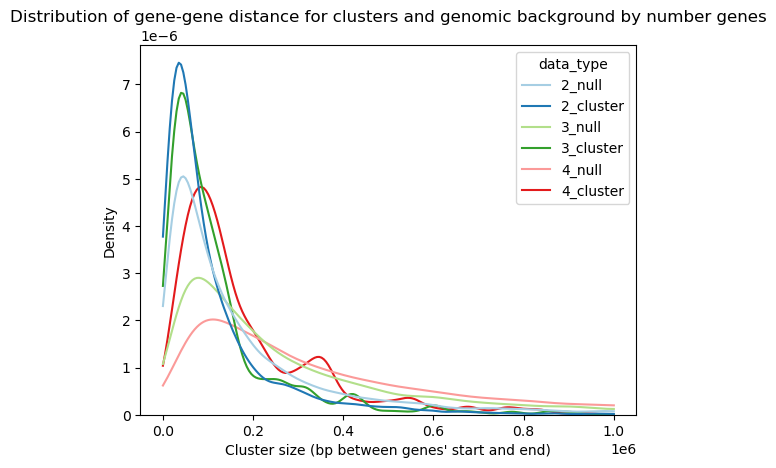

In [34]:
fig, ax = plt.subplots()

sns.kdeplot(size_plot_df, x='cluster_size', hue='data_type', clip=(0, 10**6), 
            bw_adjust=.5, fill=False, ax=ax, common_norm=False, palette = sns.color_palette("Paired"), 
            hue_order=['2_null','2_cluster','3_null','3_cluster','4_null', '4_cluster'])
plt.xlabel("Cluster size (bp between genes' start and end)")
plt.title('Distribution of gene-gene distance for clusters and genomic background by number genes')

In [39]:

# subsample size_plot_df to match number of nulls to number of clusters of each size
subsampled_null=[]
for i in range(2,5,1):
    num_samples = sum(size_plot_df['data_type'] == f'{i}_cluster') *10
    subsampled_null.append(size_plot_df[size_plot_df['data_type'] == f'{i}_null'].sample(num_samples))

# combine into one df
sub_null_size_plot_df = pd.concat([pd.concat(cluster_size_dfs), pd.concat(subsampled_null)])
# add label column
sub_null_size_plot_df['is_cluster'] = sub_null_size_plot_df['data_type'].str.contains('cluster')


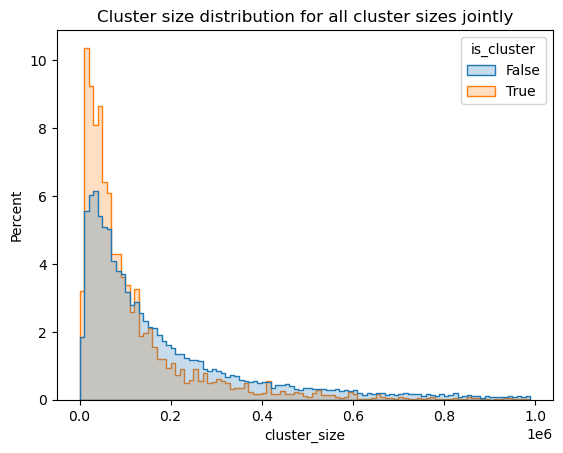

In [40]:
sns.histplot(sub_null_size_plot_df, x='cluster_size', hue='is_cluster', bins=np.arange(0, 10**6,10**4), 
             common_norm=False, stat='percent', element='step')

plt.title('Cluster size distribution for all cluster sizes jointly')
plt.show()

## bidirectional promotors
if two of the genes in the cluster are opposite strand with tss < 1000 bp away, classify as bidirecitonal promotor

In [41]:
# add cluster size from gene-gene into cluster df
# this doesn't depend on an expression filtered gencode
def get_bidirectional(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    # check all pairwise combos of genes
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                return True
    # didn't find a bidirectional promotor
    return False

In [43]:
# create one df with all tissues clusters
all_tissue_cluster_df = pd.concat(all_tissue_cluster_dfs, keys=tissue_ids)
# get bidirectional info for the clusters
all_tissue_cluster_df['bi_promotor'] = all_tissue_cluster_df.progress_apply(get_bidirectional, axis=1)

In [49]:
# get genome-wide null counts for each tissues expressed genes
all_tissues_bidirectional_nulls = []

for tissue_id in tissue_ids:
    expression_df = all_tissue_expression_dfs[tissue_id]
    # subset to ones expressed (commenting this as im moving to analyzing clusters in all tissues)
    expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
    # index based on gene id
    expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

    bidirectional_nulls={2:[], 3:[], 4:[]}

    gencode_df = expressed_gencode.sort_values(['chr', 'start', 'end'])
    for chr_id in range (1,23,1):
        chr_subset_gencode = gencode_df[gencode_df['chr'] == f'chr{21}']

        # the two conditions that must be met
        opp_strand = chr_subset_gencode['strand'] != chr_subset_gencode['strand'].shift(-1)
        close = abs(chr_subset_gencode['tss_start'] - chr_subset_gencode['tss_start'].shift(-1)) <= 1000

        # combine and extend conditions for larger clusters
        bidirectional_nulls[2] = np.concatenate([bidirectional_nulls[2], opp_strand & close])
        
    bidirectional_nulls[2] = pd.Series(bidirectional_nulls[2], dtype=bool)
    bidirectional_nulls[3] = bidirectional_nulls[2] | bidirectional_nulls[2].shift(-1)
    bidirectional_nulls[4] = bidirectional_nulls[2] | bidirectional_nulls[2].shift(-1) | bidirectional_nulls[2].shift(-2)

    all_tissues_bidirectional_nulls.append(pd.DataFrame(bidirectional_nulls))

all_tissues_bidirectional_nulls = pd.concat(all_tissues_bidirectional_nulls)


In [51]:
# get the relative fractions of bidirectional promotors or not
all_tissue_cluster_df['N_genes_clip'] = all_tissue_cluster_df['N_genes'].clip(1,4)

frac_df = {}
frac_df_noise={}
for num_genes in range(2,5):
    sub_cluster = all_tissue_cluster_df[all_tissue_cluster_df['N_genes_clip']==num_genes]
    frac_df[f'cluster_{num_genes}'] = sum(sub_cluster['bi_promotor']/len(sub_cluster))
    frac_df_noise[f'cluster_{num_genes}'] = np.sqrt(len(sub_cluster))/len(sub_cluster)

    frac_df[f'null_{num_genes}'] = sum(all_tissues_bidirectional_nulls[num_genes])/len(all_tissues_bidirectional_nulls[num_genes])
    # assume enough samples for no noise in null
    frac_df_noise[f'null_{num_genes}'] = 0

frac_bi_df = pd.DataFrame({'fraction':frac_df, 'noise':frac_df_noise})
frac_bi_df['num_genes'] = [2,2,3,3,4,4]
frac_bi_df['null_ind'] = [False,True]*3

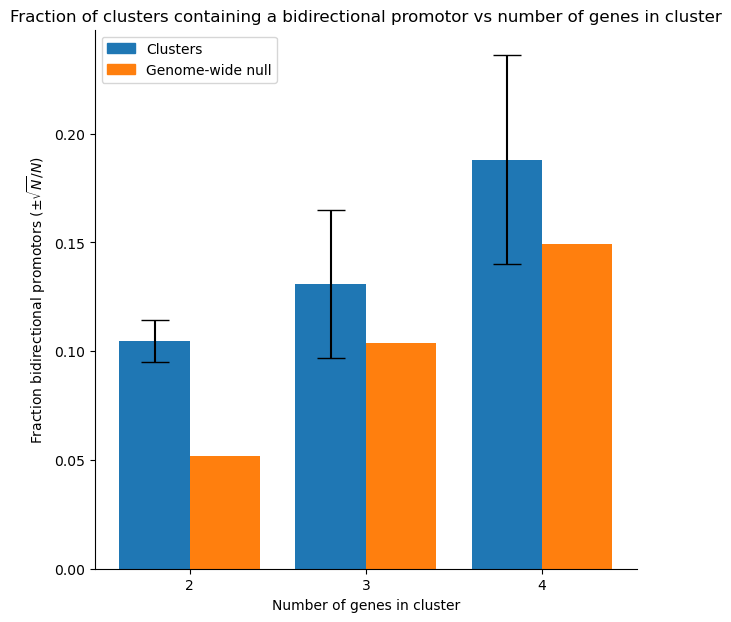

In [52]:
# plot fractions of bidirectional promotors
fig, ax = plt.subplots(figsize=(7,7))

width=.4

# for the clusters
sub_frac_df = frac_bi_df[(frac_bi_df['null_ind']==False)]
ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], width=width, color=sns.color_palette()[0])
ax.errorbar(y=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], yerr=sub_frac_df['noise'],  ls='none', color='k', capsize=10)

# for the null
sub_frac_df = frac_bi_df[(frac_bi_df['null_ind']==True)]
ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes']+width, width=width, color=sns.color_palette()[1])

# axis and labels
ax.set_xticks(sub_frac_df['num_genes'] + width / 2, ('2', '3', '4'))
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Number of genes in cluster')
ax.set_ylabel('Fraction bidirectional promotors ($\pm \sqrt{N}/N$)')
ax.set_title('Fraction of clusters containing a bidirectional promotor vs number of genes in cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend
cluster_patch = mpatches.Patch(color=sns.color_palette()[0], label='Clusters')
null_patch = mpatches.Patch(color=sns.color_palette()[1], label='Genome-wide null')
plt.legend(handles=[cluster_patch, null_patch])

## paralog frequency
how often are both genes paralogs/a nearby gene duplication?
is this something I can tell wtih go terms?

## Enhancer sharing 
* Supp data 4 from "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" (https://www.nature.com/articles/s42003-022-03831-w#data-availability) correlated atac and rna-seq acessibility for epi map regions in LCLs, showed high concordence with ABC and epi map? (this could only work for lcl type cells, which I don't really have)

* ABC for 131 biosmaples (could probably find matches for most of mine) from Nasser et al. Nature (2021): Genome-wide enhancer maps connect risk variants to disease genes. (download link: https://www.engreitzlab.org/resources) copied from /oak/stanford/groups/engreitz/public/Nasser2021


In [78]:
# load in ABC data for enhancer gene connections
full_abc_pred_df = pd.read_csv(f'{prefix}/data/references/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz', sep='\t')
full_abc_pred_df

,chr,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact,powerlaw_contact_reference,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
0,chr1,710010,710210,genic|chr1:709860-710360,genic,0.420794,LOC100288069,714068,NaN,0.815301,...,0.125372,0.123436,0.123436,0.001216,0.124652,0.052453,0.025955,0.051941,0.021762,brite_adipose-Loft2014
1,chr1,710036,710236,genic|chr1:709886-710386,genic,0.373477,LOC100288069,714068,NaN,0.843633,...,0.125372,0.123436,0.123436,0.001216,0.124652,0.046555,0.021446,0.046101,0.016866,white_adipose-Loft2014
2,chr1,710526,710956,genic|chr1:710376-711106,genic,0.776180,LOC100288069,714068,NaN,0.871313,...,0.125372,0.123436,0.123436,0.001216,0.124652,0.096752,0.032996,0.095809,0.026123,OCI-LY7-ENCODE
3,chr1,713731,714569,promoter|chr1:713581-714719,promoter,7.879375,LOC100288069,714068,NaN,0.699935,...,0.125372,0.123436,0.123436,0.001216,0.124652,0.982179,0.539952,0.972599,0.370969,A673-ENCODE
4,chr1,713743,714641,promoter|chr1:713593-714791,promoter,12.744314,LOC100288069,714068,NaN,0.815301,...,0.125372,0.123436,0.123436,0.001216,0.124652,1.588603,0.786091,1.573108,0.659092,brite_adipose-Loft2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7717387,chrX,155231339,155231539,genic|chrX:155231189-155231689,genic,0.995502,IL9R,155227245,NaN,0.699487,...,0.125372,0.123436,0.048879,0.001216,0.050095,0.049870,0.051189,0.122881,0.082033,thymus_fetal-Roadmap
7717388,chrX,155232200,155232400,genic|chrX:155232050-155232550,genic,1.714474,IL9R,155227245,NaN,0.597605,...,0.124178,0.122267,0.048882,0.001216,0.050098,0.085891,0.049620,0.209624,0.063466,CD34-positive_mobilized-Roadmap
7717389,chrX,155232225,155232425,genic|chrX:155232075-155232575,genic,2.914390,IL9R,155227245,NaN,0.581066,...,0.123643,0.121743,0.048883,0.001216,0.050099,0.146007,0.088278,0.354808,0.145605,K562-Roadmap
7717390,chrX,155233549,155233824,genic|chrX:155233399-155233974,genic,0.863398,IL9R,155227245,NaN,0.597605,...,0.100451,0.099025,0.048941,0.001216,0.050157,0.043305,0.025018,0.085498,0.025885,CD34-positive_mobilized-Roadmap


In [70]:
# load in tissue matching for ABC-gtex tissues
# this has to be done by hand
# some were clear, for those that aren't I've asked for help and put None for now

abc_gtex_match = pd.read_csv(f'{prefix}/data/references/ABC_matched_gtex.csv')
abc_gtex_match

,GTEX_tissue,ABC_biosample_id
0,Adipose_Subcutaneous,adipose_tissue-ENCODE
1,Adipose_Visceral_Omentum,brite_adipose-Loft2014
2,Artery_Tibial,NaN
3,Cells_Cultured_fibroblasts,fibroblast_of_arm-ENCODE
4,Esophagus_Mucosa,NaN
5,Esophagus_Muscularis,NaN
6,Lung,fibroblast_of_lung-Roadmap
7,Muscle_Skeletal,skeletal_muscle_myoblast-Roadmap
8,Nerve_Tibial,NaN
9,Skin_Not_Sun_Exposed_Suprapubic,NaN


In [82]:
# start on just Adipose_Subcutaneous
tissue_id =  'Adipose_Subcutaneous'
# get just the clusters for this tissue
cluster_df = all_tissue_cluster_dfs[tissue_id]
# get just the enhancer-gene connections for the matched tissue
abc_df = full_abc_pred_df[full_abc_pred_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == tissue_id]['ABC_biosample_id'].iloc[0]]
abc_df

,chr,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact,powerlaw_contact_reference,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
60,chr1,713968,714627,promoter|chr1:713818-714777,promoter,3.204471,LOC100288069,714068,NaN,0.431155,...,0.125372,0.123436,0.123436,0.001216,0.124652,0.399443,0.252502,0.395547,0.175322,adipose_tissue-ENCODE
727,chr1,840059,840731,intergenic|chr1:839909-840881,intergenic,2.853661,SAMD11,861120,NaN,0.433844,...,0.036135,0.035831,0.018852,0.001216,0.020068,0.057267,0.018993,0.102248,0.022028,adipose_tissue-ENCODE
875,chr1,859191,861220,promoter|chr1:859041-861370,promoter,6.796924,SAMD11,861120,NaN,0.433844,...,0.125372,0.123436,0.067077,0.001216,0.068293,0.464183,0.153953,0.838985,0.180745,adipose_tissue-ENCODE
931,chr1,868563,868763,genic|chr1:868413-868913,genic,0.746261,SAMD11,861120,NaN,0.433844,...,0.087493,0.086319,0.067215,0.001216,0.068431,0.051067,0.016937,0.064417,0.013877,adipose_tissue-ENCODE
1083,chr1,875720,876670,genic|chr1:875570-876820,genic,10.875093,NOC2L,894679,NaN,0.495723,...,0.039940,0.039581,0.019312,0.001216,0.020528,0.223239,0.081823,0.430449,0.098835,adipose_tissue-ENCODE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7716605,chrX,154299404,154299824,promoter|chrX:154299254-154299974,promoter,2.451035,MTCP1,154299547,NaN,0.627159,...,0.125372,0.123436,0.041811,0.001216,0.043026,0.105459,0.129395,0.302546,0.251732,adipose_tissue-ENCODE
7716606,chrX,154299404,154299824,promoter|chrX:154299254-154299974,promoter,2.451035,CMC4,154299547,NaN,0.627159,...,0.125372,0.123436,0.041811,0.001216,0.043026,0.105459,0.129395,0.302546,0.251732,adipose_tissue-ENCODE
7716607,chrX,154299404,154299824,promoter|chrX:154299254-154299974,promoter,2.451035,BRCC3,154299694,NaN,0.629949,...,0.125372,0.123436,0.041811,0.001216,0.043026,0.105459,0.129397,0.302546,0.251996,adipose_tissue-ENCODE
7716751,chrX,154444307,154444826,promoter|chrX:154444157-154444976,promoter,4.765785,VBP1,154444700,NaN,0.634940,...,0.125372,0.123436,0.037211,0.001216,0.038427,0.183135,0.253544,0.588270,0.468794,adipose_tissue-ENCODE


In [152]:
# add transcript ids to relevant abc enhancer-gene connection columns these and set as index
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], abc_df[['TargetGene','name','class']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)

In [228]:
# annotate clusters with the number of shared enhancers

def annotate_enhancers(cluster_df):
    for idx, row in cluster_df.iterrows():
        enhancer_list = gene_enhancer_df.loc[row['Transcripts'].split(',')]['enhancer']
        enhancer_list = enhancer_list[~enhancer_list.isna()]
        num_shared_enhancers = sum(enhancer_list.duplicated())
        cluster_df.loc[idx, 'num_shared_enhancers'] = num_shared_enhancers
        cluster_df.loc[idx, 'num_enhancers'] = len(enhancer_list)

annotate_enhancers(cluster_df)

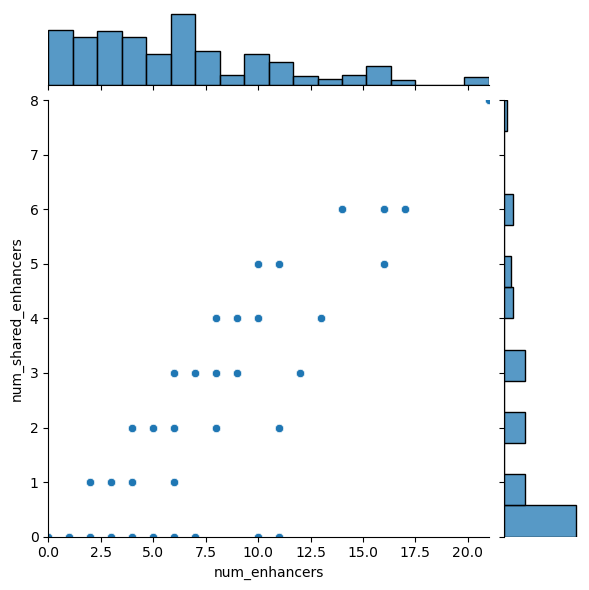

In [165]:
sns.jointplot(cluster_df, y='num_shared_enhancers', x='num_enhancers', xlim=(0, cluster_df['num_enhancers'].max()), ylim=(0,cluster_df['num_shared_enhancers'].max()))

<AxesSubplot: xlabel='Count', ylabel='num_shared_enhancers'>

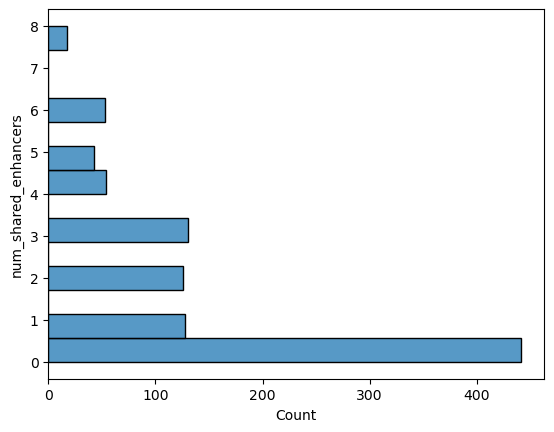

In [248]:
sns.histplot(cluster_df, y='num_shared_enhancers',)

weird that these are 3 all the same height - maybe my shared enhancer code is wrong??

Should the null be idstance matched or tss-tss distance match (probs tss-tss)

In [171]:
# subset to expressed genes for the null
expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
# index based on gene id
#expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

In [226]:
# null distribution of distance matched clusters (do a seperate null for each cluster size?)

# to start just generate all possible clusters, annotated with sizes
def get_null_clusters(gencode_df, num_genes):
    # sort
    gencode_df = gencode_df.sort_values(['chr', 'start', 'end'])
    # on a per chrom basis
    null_cluster_dfs = []
    for chr_id in range (1,23,1):
        chr_subset_gencode = gencode_df[gencode_df['chr'] == f'chr{chr_id}']
        transcripts = chr_subset_gencode['transcript_id'].astype(str) + ',' + chr_subset_gencode['transcript_id'].shift(-(num_genes-1)).astype(str)
        chr_sizes = chr_subset_gencode['end'].shift(-(num_genes-1)) - chr_subset_gencode['start']
        # trim off the blanks created from shifting
        transcripts = transcripts.iloc[:-(num_genes-1)]
        chr_sizes = chr_sizes.iloc[:-(num_genes-1)]

        # select those that are not already clusters
        cluster_start_ids = get_cluster_start_ids(cluster_df)
        this_cluster_size_start_ids = np.concatenate(cluster_start_ids[num_genes:])
        in_cluster_bool = pd.Series(chr_subset_gencode['transcript_id'].iloc[:-(num_genes-1)]).isin(this_cluster_size_start_ids).values

        # add df to list
        null_cluster_dfs.append(pd.DataFrame({'Transcripts':transcripts[~in_cluster_bool], 'size':chr_sizes[~in_cluster_bool]}))
    null_df = pd.concat(null_cluster_dfs)
    null_df.reset_index(drop=True, inplace=True)
    return null_df


In [206]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)

In [208]:
# add size to the cluster
cluster_df['size'] = cluster_df.apply(get_cluster_size, axis=1)

In [ ]:
# get a pairs null df
full_null_df = get_null_clusters(expressed_gencode, 2)

Text(0.5, 1.0, 'Distance distribution before resampling (num_genes  = 2)')

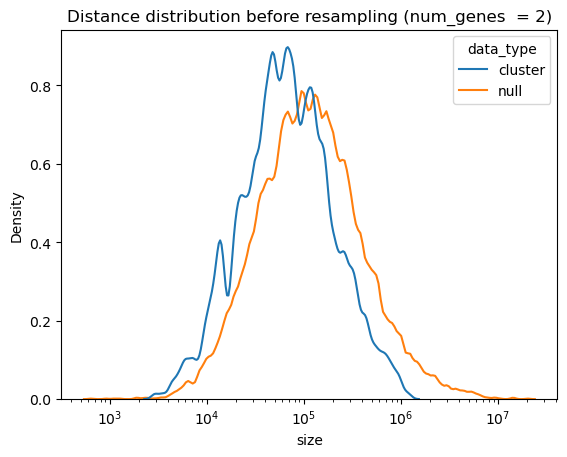

In [220]:
# size distribution before
join_df = pd.concat([cluster_df[cluster_df['N_genes']==2], full_null_df], keys=['cluster', 'null'], names=['data_type', 'id'])
sns.kdeplot(join_df, x='size', hue='data_type', bw_adjust=.3, common_norm=False, log_scale=(10,None))
plt.title('Distance distribution before resampling (num_genes  = 2)')

In [224]:

cluster_df['normed_log_size'] = np.log10(cluster_df['size'])/np.log10(join_df['size'].max())
full_null_df['normed_log_size'] = np.log10(full_null_df['size'])/np.log10(join_df['size'].max())


resamp_idxs = resample_dist(cluster_df[cluster_df['N_genes']==2]['normed_log_size'], full_null_df['normed_log_size'], n=10000)

<AxesSubplot: xlabel='size', ylabel='Density'>

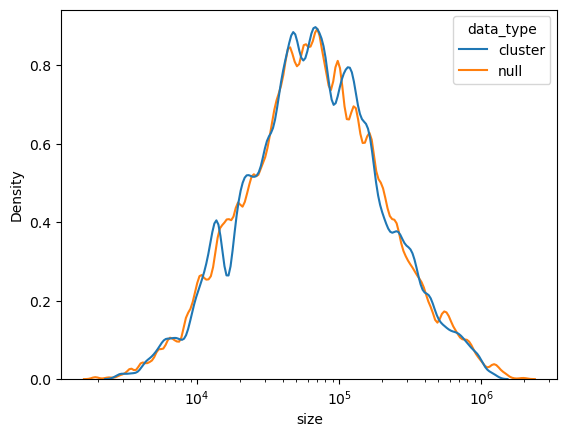

In [225]:
# size distribution after resampling
join_df = pd.concat([cluster_df[cluster_df['N_genes']==2], full_null_df.reset_index().iloc[resamp_idxs]], keys=['cluster', 'null'], names=['data_type', 'id'])
sns.kdeplot(join_df, x='size', hue='data_type', bw_adjust=.3, common_norm=False, log_scale=(10,None))

In [242]:
# get the fraction of genes with shared enhancers

def get_fraction(column_name):

    frac_df = {}
    frac_df_noise={}
    for num_genes in range(2,5):
        # get a null dist
        full_null_df = get_null_clusters(expressed_gencode, num_genes)
        max_size = np.log10(pd.concat([cluster_df, full_null_df])['size'].max())

        # norm the sizes
        full_null_df['normed_log_size'] = np.log10(full_null_df['size'])/max_size
        sub_cluster = cluster_df[cluster_df['N_genes']==num_genes]

        # resample to match distance
        resamp_idxs = resample_dist(np.log10(sub_cluster['size'])/max_size, full_null_df['normed_log_size'], n=1000)
        resamp_null = full_null_df.reset_index().iloc[resamp_idxs]

        # get the enhancer sharing for the null
        annotate_enhancers(resamp_null)

        frac_df[f'cluster_{num_genes}'] = sum(sub_cluster[column_name]>0)/len(sub_cluster)
        frac_df_noise[f'cluster_{num_genes}'] = np.sqrt(len(sub_cluster))/len(sub_cluster)

        frac_df[f'null_{num_genes}'] = sum(resamp_null[column_name]>0)/len(resamp_null)
        # assume enough samples for no noise in null
        frac_df_noise[f'null_{num_genes}'] = np.sqrt(len(resamp_null))/len(resamp_null)

    frac_df = pd.DataFrame({'fraction':frac_df, 'noise':frac_df_noise})
    frac_df['num_genes'] = [2,2,3,3,4,4]
    frac_df['null_ind'] = [False,True]*3

    return frac_df

In [246]:
def plot_fracs(ax, frac_df, fraction_label):

    # plot fractions of annotation
    width=.4

    # for the clusters
    sub_frac_df = frac_df[(frac_df['null_ind']==False)]
    ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], width=width, color=sns.color_palette()[0])
    ax.errorbar(y=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], yerr=sub_frac_df['noise'],  ls='none', color='k', capsize=10)

    # for the null
    sub_frac_df = frac_df[(frac_df['null_ind']==True)]
    ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes']+width, width=width, color=sns.color_palette()[1])

    # axis and labels
    ax.set_xticks(sub_frac_df['num_genes'] + width / 2, ('2', '3', '4'))
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlabel('Number of genes in cluster')
    ax.set_ylabel(f'Fraction {fraction_label}')
    ax.set_title(f'Fraction of clusters containing a {fraction_label} vs number of genes in cluster')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # legend
    cluster_patch = mpatches.Patch(color=sns.color_palette()[0], label='Clusters')
    null_patch = mpatches.Patch(color=sns.color_palette()[1], label='Genome-wide null')
    plt.legend(handles=[cluster_patch, null_patch])

    return ax

In [243]:
frac_shared_enhancer_df = get_fraction('num_shared_enhancers')

/local/scratch/klawren/slrmtmp.43096443/ipykernel_41412/2510309917.py:17: RuntimeWarning: divide by zero encountered in divide
  sampling_weight = target_prob(bins) / candidate_prob(bins)


/local/scratch/klawren/slrmtmp.43096443/ipykernel_41412/2510309917.py:17: RuntimeWarning: divide by zero encountered in divide
  sampling_weight = target_prob(bins) / candidate_prob(bins)


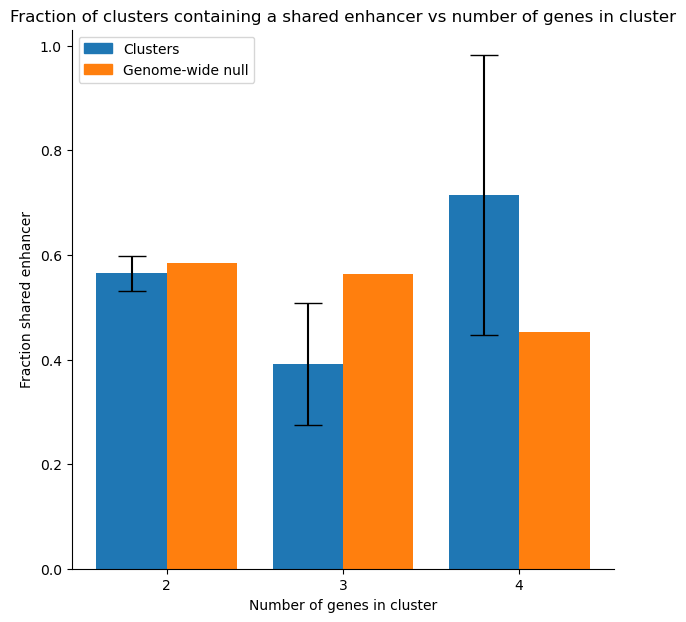

In [247]:
fig, ax = plt.subplots(figsize=(7,7))
plot_fracs(ax, frac_shared_enhancer_df, 'shared enhancer')
plt.show()

/local/scratch/klawren/slrmtmp.43096443/ipykernel_41412/2510309917.py:17: RuntimeWarning: divide by zero encountered in divide
  sampling_weight = target_prob(bins) / candidate_prob(bins)
/local/scratch/klawren/slrmtmp.43096443/ipykernel_41412/2510309917.py:17: RuntimeWarning: divide by zero encountered in divide
  sampling_weight = target_prob(bins) / candidate_prob(bins)


NameError: name 'frac_enhancer_df' is not defined

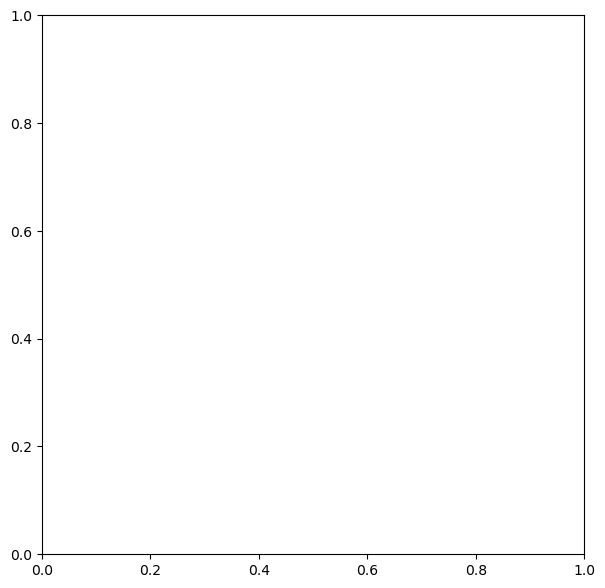

In [249]:
frac_shared_enhancer_df = get_fraction('num_enhancers')
fig, ax = plt.subplots(figsize=(7,7))
plot_fracs(ax, frac_enhancer_df, 'has enhancer')
plt.show()